(1236, 2888)
(1236, 2881)
训练集数据 shape: (1000, 360, 8)
训练集标签 shape: (1000,)
测试集数据 shape: (236, 360, 8)
测试集标签 shape: (236,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
________________________________________________________________

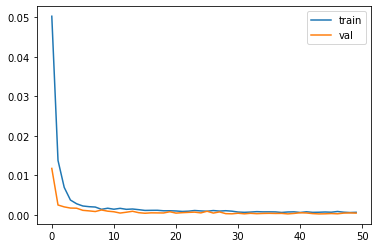

0.0004217803943902254


In [1]:
# 导入相关包
import os
import math
import copy
import numpy as np
import pandas as pd
import joblib
from sklearn import preprocessing
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Dropout
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
#datacleaning()

# 读取数据
a=np.loadtxt('train_input.csv',dtype=np.float64)
b=np.loadtxt('output.txt',dtype=np.float64)
b = b[:,np.newaxis]
values=np.concatenate((a,b),axis=1)

data = copy.deepcopy(values)
data = pd.DataFrame(data)
data.dropna(inplace=True)

# 查看数据分布
#data.plot(subplots=True, figsize=(20, 10), legend = True)
#data.head()
def series_to_supervised(data, n_in, n_out):
    """
    数据处理
    :param data:数据
    :param n_in:输入特征个数
    :param n_out:目标值
    :param dropnan:是否删除 Nan 值 
    :return:
    """
    df = pd.DataFrame(data)
    n_vars = df.shape[1]  # n_vars 列数
    cols, names = list(), list()
    
    # 时间间隔跨度, 时间点个数，共 n_in 个
    # 首先添加当前时刻之前的时间点
    for i in range(n_in - 1, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 然后添加当前时刻
    cols.append(df)
    names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]

    # 添加 target 为未来 n_out 分钟后时刻的温度
    cols.append(df.shift(-n_out))
    names += [('var%d(t+%d)' % (j + 1, n_out)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除缺失值
    agg.dropna(inplace=True)
    
    return agg
# 确保所有数据是 float64 类型
data = data.astype('float64')
'''''
# 归一化特征
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
joblib.dump(scaler, 'results/scaler.save')
np.savetxt('results/scaled_data.csv',scaled_data)
'''
scaled_data = data
# 构建成监督学习数据集
number1=360
number2=1
reframed = series_to_supervised(scaled_data, number1, number2)
reframed.head()
print(reframed.shape)

# 丢弃我们不想预测的列,这里预测的是最后一列，丢弃其他列
drop_col = [number1*8, number1*8+1, number1*8+2, number1*8+3, number1*8+4, number1*8+5, number1*8+6]
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
reframed.head()

# 把数据分为训练集和测试集
values = reframed.values
print(values.shape)

train = values[:1000, :] 
test = values[1000:, :]  

# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# 把输入重塑成符合LSTM输入的3D格式 [样例， 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], number1, 8))
test_X = test_X.reshape((test_X.shape[0], number1, 8))

print("训练集数据 shape:", train_X.shape)
print("训练集标签 shape:", train_y.shape)
print("测试集数据 shape:", test_X.shape)
print("测试集标签 shape:", test_y.shape)
"""
# 设计LSTM网络
model = Sequential()
model.add(LSTM(units=128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("relu"))
model.summary()
"""
"""
model = Sequential()
model.add(LSTM(units=128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))
model.add(Activation("relu"))
# model.add(Activation("softsign")) 
model.summary()
"""

model = Sequential()
model.add(LSTM(units=32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Activation("relu"))
model.add(Dense(units=16))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()


"""
#nananan--bad
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=False, activation='relu'), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()
"""
# 配置训练方法
model.compile(loss='mse', optimizer='adam')

tbCallBack = TensorBoard(log_dir='./results/tb_lstmresults',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
                 batch_size=64,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

# 拟合网络
history = model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), callbacks=[tbCallBack], verbose=1, shuffle=True)

# 保存模型
model.save('./results/lstm.h5')

# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.savefig('results/LSTM_loss.jpg')
plt.show()

# 模型评估
score = model.evaluate(test_X, test_y, verbose=0)
print(score)

In [2]:
import numpy as np
import pandas as pd
import os
import math
import copy
import tensorflow.keras.backend as K 
from sklearn import preprocessing
from tensorflow.keras.models import load_model
import joblib

# 加载模型
model_path = 'results/lstm.h5'
model = load_model(model_path)

def predict(sequence):
    '''
    对输入序列进行预测，sequence为number1时间步的时序数据，
    输出结果为该序列1时间步后的预测值
    param: sequence: np.array矩阵 shape:[number1,8] [时间步, 特征]，
                     其中特征的索引顺序与数据集相同
    return: 预测度（标量），浮点数表示，限定使用np.float64或者python的float类型
    '''
    # 数据处理
    sequence = sequence.astype('float64')
    #scaler = joblib.load('results/scaler.save')
    #sequence = scaler.transform(sequence)
    sequence = np.expand_dims(sequence, 0).repeat(1, axis=0)
    pre_t = model.predict(sequence)
    
    '''''
    # scaler只能对整体反归一化，构造两个空矩阵
    temp_array = np.ones((len(sequence),7))
    # 反归一化
    predicted_seq = np.concatenate((temp_array, pre_t), axis=1)
    predicted_seq = scaler.inverse_transform(predicted_seq)
    print(predicted_seq)
    pre_t = predicted_seq[:,7]
    #print(pre_t)
    '''
    pre_t = np.float64(pre_t)
    return pre_t

In [41]:
# 读取数据
a=np.loadtxt('train_input.csv',dtype=np.float64)
b=np.loadtxt('output.txt',dtype=np.float64)
b = b[:,np.newaxis]
c=np.loadtxt('test_input.csv',dtype=np.float64)
d=np.ones([798,1], dtype = np.float64)
values=np.concatenate((a,b),axis=1)
values2=np.concatenate((c,d),axis=1)
values = values[-number1:,:]
print(values.shape)
for i in range(798):
    print(predict(values))
    pre=predict(values)
    d[i] = pre
    print(d[i])
    values = np.delete(values, 0, axis = 0)
    values2[i,7]=d[i]
    e = values2[i]
    e = e[np.newaxis,:]
    #print(e.shape)
    values=np.concatenate((values,e),axis=0)
    #print(values.shape)
data = pd.DataFrame(values2)
writer = pd.ExcelWriter('/results/TEST.xlsx')
data.to_excel(writer, 'page_1', float_format='%.32f')		# ‘page_1’是写入excel的sheet名
writer.save()
writer.close()

(360, 8)
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.27226394]]
0.2722639385705642
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.27226394]]
[0.27226394]
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.2571278 ]]
0.2571278004495583
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.2571278 ]]
[0.2571278]
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.26540769]]
0.26540769472266207
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.26540769]]
[0.26540769]
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.32784133]]
0.32784132630712165
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.32784133]]
[0.32784133]
[[0.81292611 0.91138657 0.98764215 0.97617675 0.98342088 0.99863387
  0.99477735 0.35382537]]
0.35382537311102

D:\Programs\anaconda\lib\site-packages\xlsxwriter\workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
